In [12]:
import csv
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# training dataset
# cost_model_file = '../one-tm-seed-1-pods-4-data/costs_fat_tree_4_pods_1.csv'
# opt_value_file = '../values-seed-1-pods-4/values_target.csv'
# learned_value_file = '../values-seed-1-pods-4/values_model_estimated.csv'

# testing unseen dataset
# cost_model_file = '../one-tm-seed-2-pods-4-data/costs_fat_tree_4_pods_2.csv'
# opt_value_file = '../values-seed-2-pods-4/values_target.csv'
# learned_value_file = '../values-seed-2-pods-4/values_model_estimated.csv'
cost_model_file = '/data/one-tm-seed-102-pods-4-data/costs_fat_tree_4_pods_102.csv'
opt_value_file = '/data/values-seed-102-pods-4/values_target.csv'
learned_value_file = '/data/values-seed-102-pods-4/values_model_estimated.csv'

max_num_steps = 4
switch_to_update = set([0, 1, 2, 3, 4, 5, 8, 9, 12, 13, 16, 17])

In [14]:
def read_values(file_path):
    values = [[] for _ in range(max_num_steps)]
    switch_idx = [[] for _ in range(max_num_steps)]
    switch_idx_map = [{} for _ in range(max_num_steps)]

    with open(file_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            val = float(row[0])
            num_steps_left = int(row[1]) - 1  # for idx
            
            try:
                switch = [int(i) for i in row[2:]]
            except ValueError:
                switch = []
            
            values[num_steps_left].append(val)
            switch_idx[num_steps_left].append(switch)
            switch_idx_map[num_steps_left][tuple(sorted(switch))] = val

    return values, switch_idx, switch_idx_map

In [15]:
def read_cost_model(file_path):
    cost_model = {}  # switch_down (sorted) -> cost
    
    lc = 0
    with open(file_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if lc == 0:
                lc += 1
                continue
                
            cost = float(row[0])
            switch_down = [int(i) for i in row[1:]]
            
            switch_key = tuple(sorted(switch_down))
            cost_model[switch_key] = cost

    return cost_model

In [16]:
cost_model = read_cost_model(cost_model_file)
opt_values, opt_switch_idx, opt_switch_map = read_values(opt_value_file)
learned_values, learned_switch_idx, learned_switch_map = read_values(learned_value_file)

In [17]:
if () not in cost_model:
    cost_model[()] = 0

In [18]:
switches_left = set(switch_to_update)
cost_so_far = 0
print('')

for i in range(max_num_steps, 0, -1):
    print('Updating switches {} in {} steps'.format(
      switches_left, i))

    step_idx = i - 1
    
    opt_val = opt_switch_map[step_idx][tuple(sorted(switches_left))]
    learned_val = learned_switch_map[step_idx][tuple(sorted(switches_left))]
    
    print(('Optimal total value: {}, ' + 
         'learned predicted total value: {}').format(
         opt_val, learned_val))
    
    # plan ahead one step
    if i > 1:
        cost = np.inf
        min_next_val = np.inf
        switches_down = set()
        for (nv, sl) in zip(learned_values[step_idx - 1], 
                            learned_switch_idx[step_idx - 1]):

            # current switch left should contain next one
            if len(set(sl) - switches_left) == 0:
                sd = switches_left - set(sl)
                c = cost_model[tuple(sorted(sd))]
                if nv + c < min_next_val:
                    cost = c
                    min_next_val = nv + c
                    switches_down = sd
        
        cost_so_far += cost
        
        print('Switches to take down: {}, cost + future value: {} + {}, cost so far {}'.format(
              switches_down, cost, min_next_val - cost, cost_so_far))
        
        # take down these switches
        switches_left -= switches_down
    
    else:
        
        cost = cost_model[tuple(sorted(switches_left))]
        cost_so_far += cost
        print('Switches to take down: {}, cost {}, cost so far {}'.format(
            switches_left, cost, cost_so_far))
    print('')



Updating switches {0, 1, 2, 3, 4, 5, 8, 9, 12, 13, 16, 17} in 4 steps
Optimal total value: 0.2, learned predicted total value: 0.2966504
Switches to take down: {0}, cost + future value: 0.0 + 0.288481, cost so far 0.0

Updating switches {1, 2, 3, 4, 5, 8, 9, 12, 13, 16, 17} in 3 steps
Optimal total value: 0.2, learned predicted total value: 0.288481
Switches to take down: {3}, cost + future value: 0.0 + 0.28836066, cost so far 0.0

Updating switches {1, 2, 4, 5, 8, 9, 12, 13, 16, 17} in 2 steps
Optimal total value: 0.2, learned predicted total value: 0.28836066
Switches to take down: {2, 5, 9, 13, 17}, cost + future value: 0.1 + 0.3614022, cost so far 0.1

Updating switches {1, 4, 8, 12, 16} in 1 steps
Optimal total value: 0.1, learned predicted total value: 0.3614022
Switches to take down: {1, 4, 8, 12, 16}, cost 0.1, cost so far 0.2



In [19]:
# some further analysis for the second last step planning

# to_update = set([1, 2, 4, 5, 8, 9, 12, 13, 16, 17])
# to_update = set([0, 2, 4, 5, 8, 9, 12, 13, 16, 17])
to_update = set([1, 2, 4, 5, 8, 9, 12, 13, 16, 17])

In [20]:
lr_vals = []
opt_vals = []
sw_updates = []
for sw in opt_switch_map[1]:
    if len(set(sw) - to_update) == 0:
        down_sw = to_update - set(sw)
        c = cost_model[tuple(sorted(down_sw))]
        lr_vals.append(c + learned_switch_map[0][sw])
        opt_vals.append(c + opt_switch_map[0][sw])
        sw_updates.append(down_sw)

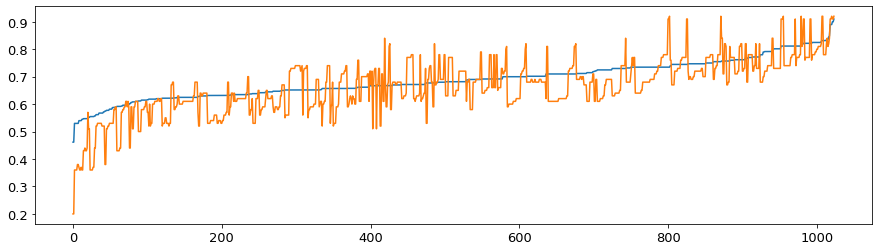

In [21]:
plt.figure(figsize=(15, 4))
sorted_lr_vals = sorted(lr_vals)
sorted_opt_vals = [x for _,x in sorted(zip(lr_vals, opt_vals))]
plt.plot(sorted_lr_vals)
plt.plot(sorted_opt_vals)

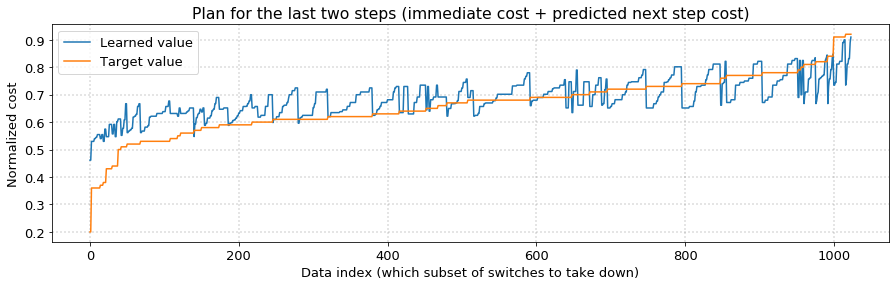

In [22]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(15, 4))
sorted_opt_vals = sorted(opt_vals)
sorted_lr_vals = [x for _,x in sorted(zip(opt_vals, lr_vals))]
plt.plot(sorted_lr_vals)
plt.plot(sorted_opt_vals)
plt.title('Plan for the last two steps (immediate cost + predicted next step cost)')
plt.legend(['Learned value', 'Target value'])
plt.ylabel('Normalized cost')
plt.xlabel('Data index (which subset of switches to take down)')
plt.grid(linestyle=(0, (10, 10)), color='black', linewidth=0.2)